In [66]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [68]:
# Load the first dataset
df_1 = pd.read_csv('df_1_act.csv')
df_1.head(3)

,Unnamed: 0,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,0,JP902_1,EXC,1.062500,-0.038696,0.670588,-0.061195,0.006330,0.000880,0.000066
1,1,JP903_1,EXC,1.750000,-0.039856,1.126786,-0.054889,0.004605,0.000627,0.000092
2,2,JP905_1,EXC,1.391667,-0.036766,0.802096,-0.058734,0.005968,0.000710,0.000054


In [69]:
# Load the second dataset
df_2 = pd.read_csv('df_2_act.csv')
df_2.head(3)

,Unnamed: 0,cell_id,cell_type,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,0,JP902_1,EXC,13,[ 1.63032302 1.36424201 1.23725137 0.951374...,1.205101,-0.004314,[-0.05661346 -0.0565887 -0.0566137 ... -0.05...,-56.567212,-56.279934,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 1.53846154 0...,0.384712,0.384712
1,1,JP903_1,EXC,13,[ 5.59008105 5.36690932 5.72071861 5.864409...,5.463008,7.853982,[-0.06675505 -0.06674783 -0.0667613 ... -0.06...,-66.712320,-66.468130,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 1...,0.000000,0.384712
2,2,JP905_1,EXC,14,[5.20685063 5.28445094 5.3122831 5.32105406 5...,5.774538,5.002845,[-0.05909152 -0.05907611 -0.05908348 ... -0.05...,-58.051123,-55.833821,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 0...,0.000000,1.071696


## Between excitatory and inhibitory

In [70]:
# Merge them and suppress unwanted columns
df_test1 = df_1.merge(df_2, on=['cell_id', 'cell_type'])
df_test1 = df_test1.drop(['Unnamed: 0_x', 'Unnamed: 0_y','cell_id', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth'], axis=1)

value1 = df_test1['cell_type']=='EXC'

df_test1['cell_type']=value1

index_col = list(df_test1['cell_type'].unique())

# Transform the labels into numbers
df_test1['cell_type'] = df_test1['cell_type'].apply(index_col.index)


In [71]:
# keep mean firing rate, sd firing rate, mean ap duration, sd ap duration, mean vm, sd vm
#df_test1 = df_test1.drop(['ap_threshold','fft_low','fft_high','std_vm',],axis=1)
df_test1.fillna(0, inplace=True)


In [72]:
# Create the X, y datasets
X = df_test1.loc[:, df_test1.columns != 'cell_type']
y = df_test1['cell_type']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Multiple Logistic Regression

Logistic Regression Accuracy: 0.8292682926829268


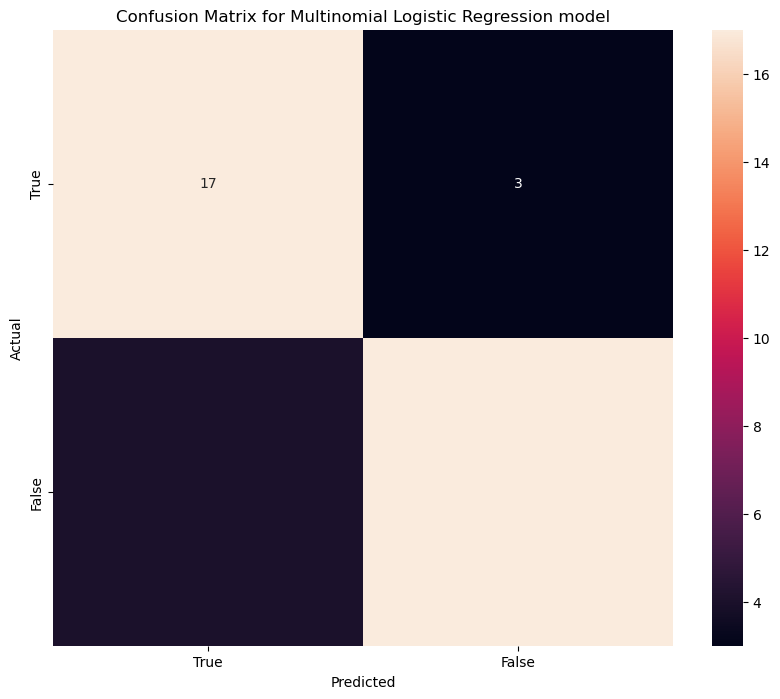

In [73]:
# Create Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm_lr, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lr, annot=True)
plt.title('Confusion Matrix for Multinomial Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest

Random Forest accuracy: 0.9024390243902439


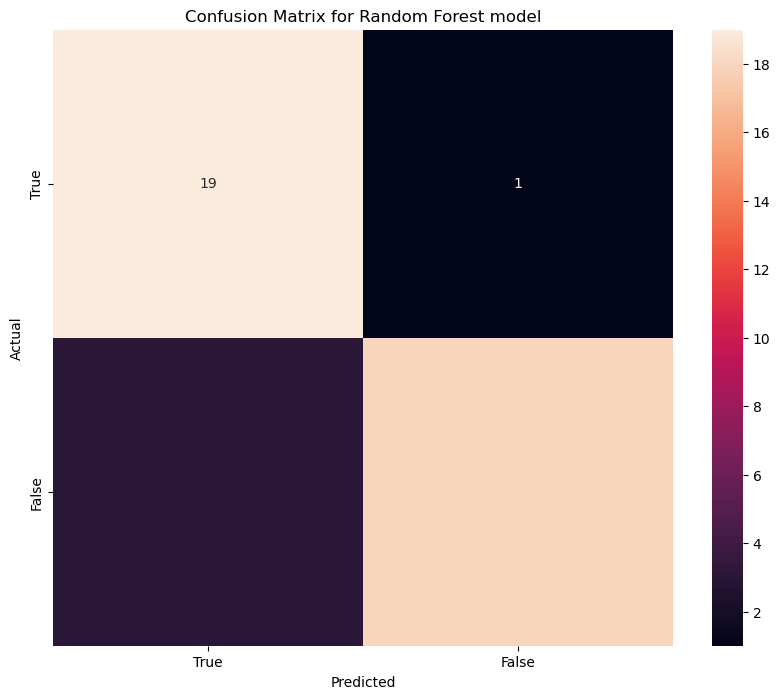

In [74]:
# Create Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
#y_probs_rf = rf.predict_proba(X_test)
#roc_auc_rf = roc_auc_score(y_test, y_probs_rf, multi_class='ovr', average='micro')
#fpr_rf, tpr_rf, _ = roc_curve(y_test.ravel(), y_probs_rf.ravel())

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest accuracy: {accuracy_rf}')

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_rf, annot=True)
plt.title('Confusion Matrix for Random Forest model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### K Nearest Neighbors

KNN accuracy: 0.8048780487804879


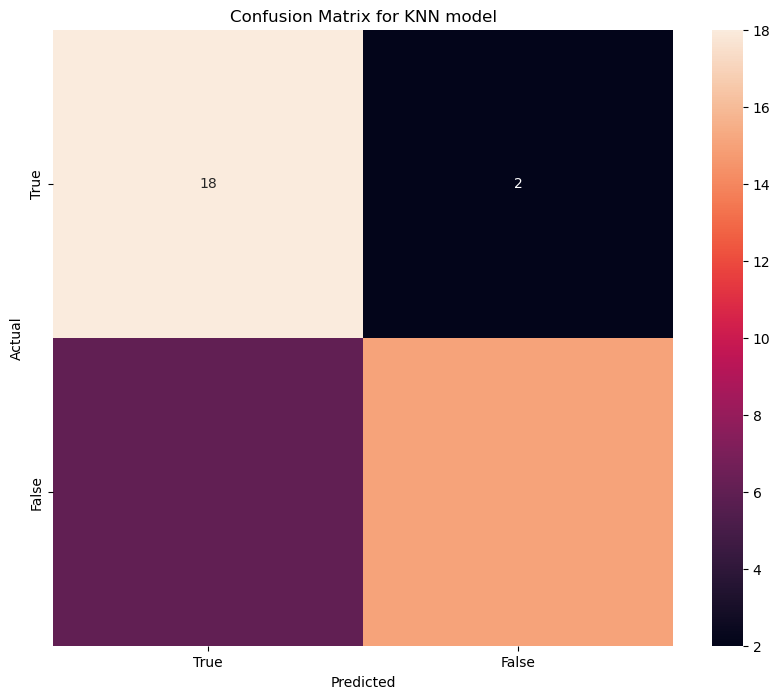

In [75]:
# Create knn model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN accuracy: {accuracy_knn}')

# Create confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_df_knn = pd.DataFrame(cm_knn, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_knn, annot=True)
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Support Vector Machine

SVM accuracy: 0.8536585365853658


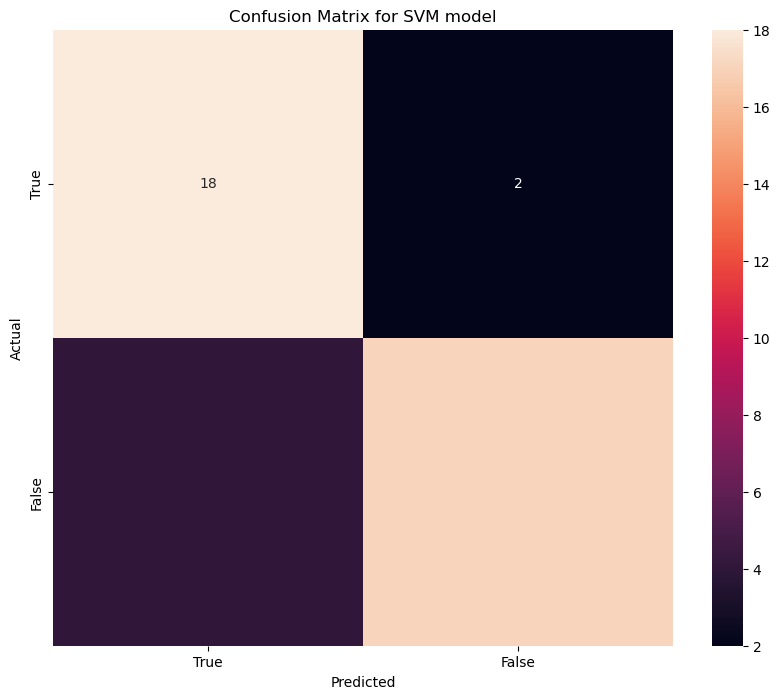

In [76]:
# Create SVM model
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM accuracy: {accuracy_svm}')

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_svm, annot=True)
plt.title('Confusion Matrix for SVM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Between Inhibitory cells

In [77]:
# Merge them and suppress unwanted columns
df_test2 = df_1.merge(df_2, on=['cell_id', 'cell_type'])
df_test2 = df_test2.drop(['Unnamed: 0_x', 'Unnamed: 0_y','cell_id', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth'], axis=1)

# remove excitatory cells
excitatory_cells = list(np.where(df_test2['cell_type']=='EXC')[0])
df_test2 = df_test2.drop(excitatory_cells,axis=0)
# reset indices
df_test2.reset_index(drop=True,inplace=True)


In [78]:
index_col = list(df_test2['cell_type'].unique())

# Transform the labels into numbers
df_test2['cell_type'] = df_test2['cell_type'].apply(index_col.index)
df_test2.head(1)

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,numb_events,wp_amplitude_pre,wp_amplitude_post,vm_amplitude_pre,vm_amplitude_post,ap_fr_pre,ap_fr_post
0,0,0.257143,-0.045133,1.625,-0.065787,0.00474,0.000618,0.00006,6,205.15501,207.363301,-47.294071,-51.192514,9.168959,6.668334


In [79]:
#df_test2.insert(loc=np.shape(df_test2)[1],column='delta_fr', value=df_test2['ap_fr_post']-df_test2['ap_fr_pre'])
#df_test2.insert(loc=np.shape(df_test2)[1],column='delta_vm', value=df_test2['vm_amplitude_post']-df_test2['vm_amplitude_pre'])
#df_test2.insert(loc=np.shape(df_test2)[1],column='deltaFR_vs_deltaAMP', value=df_test2['delta_fr']/df_test2['delta_vm'])
#df_test2['deltaFR_vs_deltaAMP'] = df_test2['deltaFR_vs_deltaAMP'].fillna(0)
#df_test2 = df_test2.drop(['delta_fr','delta_vm'],axis=1)

In [80]:
# keep mean firing rate, mean ap duration, sd vm, fft_low
#df_test2 = df_test2.drop(['fft_high'],axis=1)
df_test2.fillna(0, inplace=True)

In [81]:
# Create the X, y datasets
X = df_test2.loc[:, df_test2.columns != 'cell_type']
y = df_test2['cell_type']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Multiple Logistic Regression

Logistic Regression Accuracy: 0.7857142857142857


c:\Users\nicol\Anaconda3\envs\bio482\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


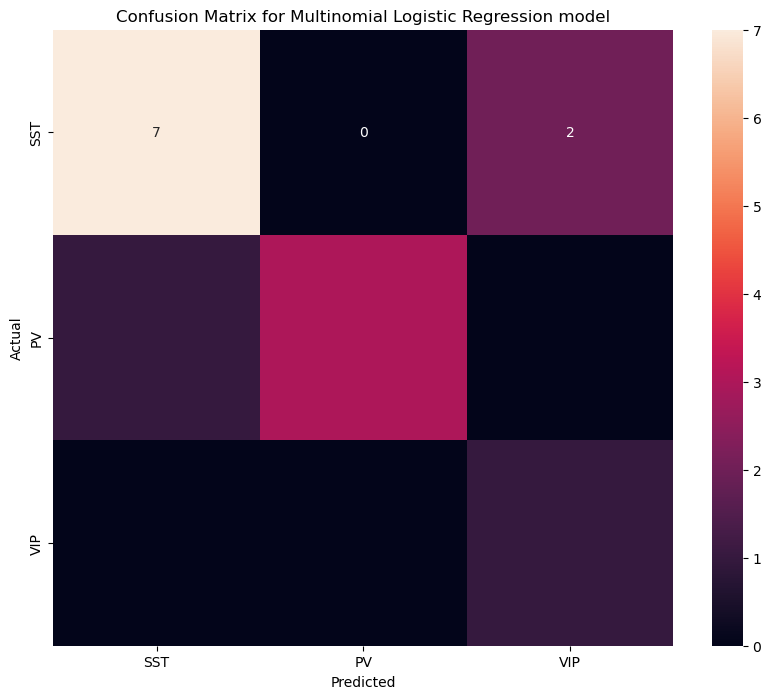

In [82]:
# Create Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm_lr, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lr, annot=True)
plt.title('Confusion Matrix for Multinomial Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Random Forest

Random Forest accuracy: 0.7142857142857143


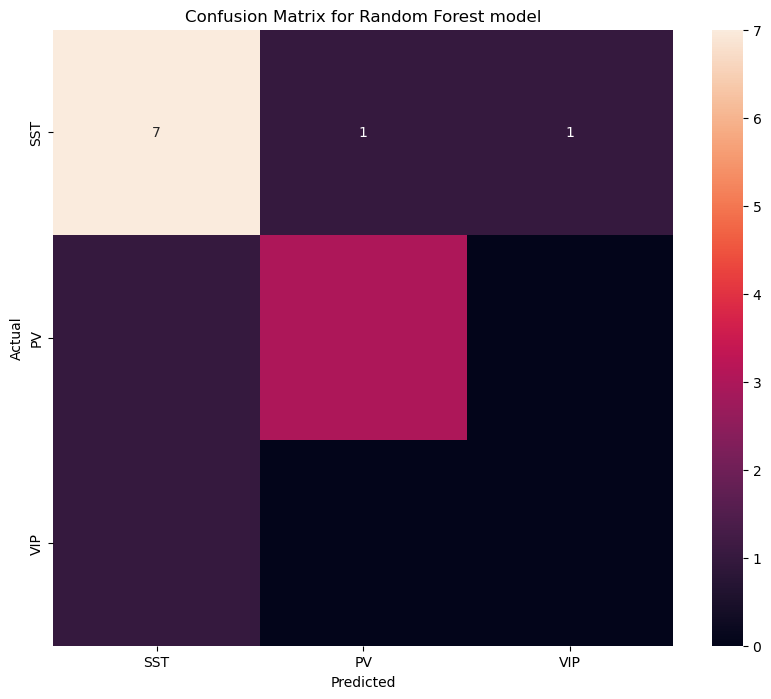

In [83]:
# Create Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
#y_probs_rf = rf.predict_proba(X_test)
#roc_auc_rf = roc_auc_score(y_test, y_probs_rf, multi_class='ovr', average='micro')
#fpr_rf, tpr_rf, _ = roc_curve(y_test.ravel(), y_probs_rf.ravel())

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest accuracy: {accuracy_rf}')

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_rf, annot=True)
plt.title('Confusion Matrix for Random Forest model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### K Nearest Neighbors

KNN accuracy: 0.9285714285714286


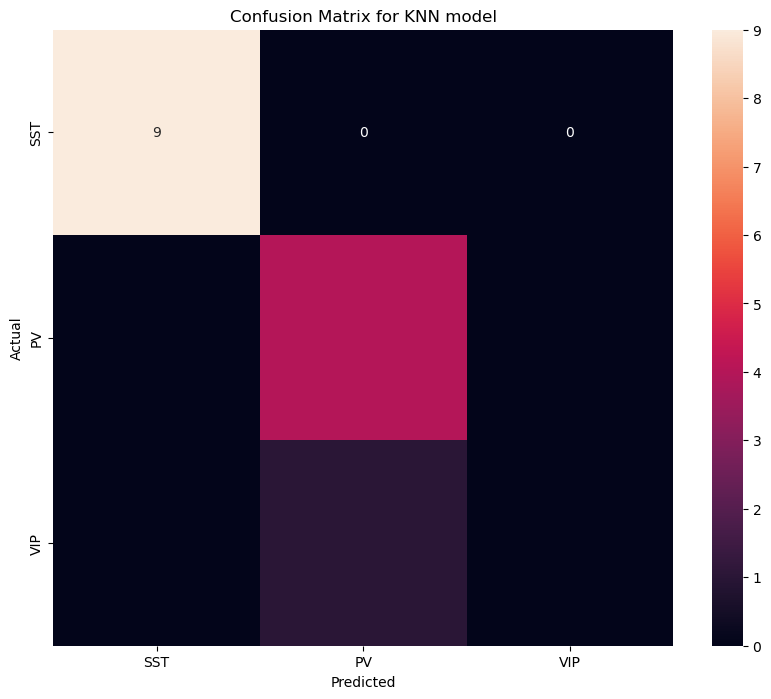

In [84]:
# Create knn model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN accuracy: {accuracy_knn}')

# Create confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_df_knn = pd.DataFrame(cm_knn, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_knn, annot=True)
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Support Vector Machine

SVM accuracy: 0.8571428571428571


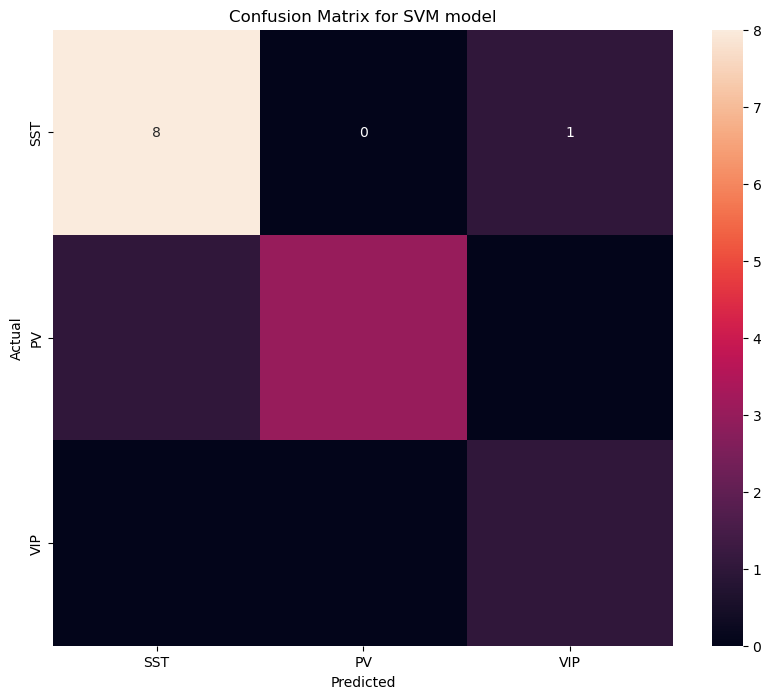

In [85]:
# Create SVM model
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM accuracy: {accuracy_svm}')

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_svm, annot=True)
plt.title('Confusion Matrix for SVM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()